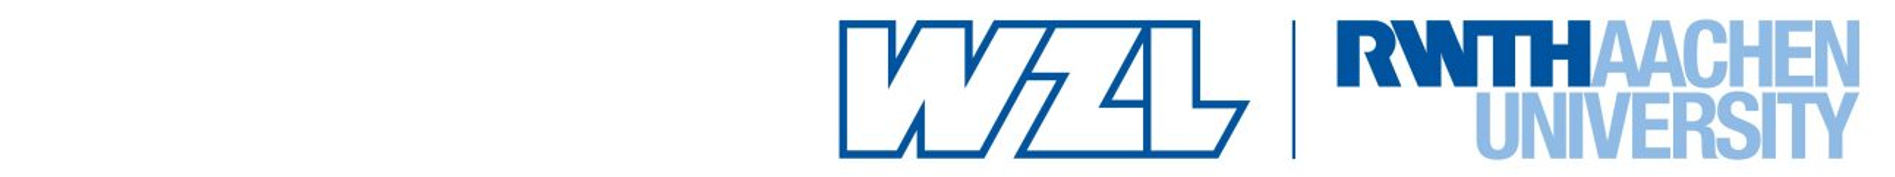

In [35]:
from IPython.display import Image
Image(filename='wzl_header.png') 

## Predictive Quality mittels künstlicher Intelligenz in der Produktion

Im Folgenden wird anhand eines Anwendungsbeispiels dargestellt, wie mittels Machine Learning Algorithmen (genauer: künstliche neuronale Netze) fehlerbehaftete Bauteile in der Produktion prädiktiv ermittelt werden. Um die Performance in Relation zu setzen, wird die Fehlerdetektion mit denen einer einfachen Regelkarte verglichen. Anschließend wird das Vorgehen einer herkömmlichen Stichprobenprüfung gegenüberstellt und Einsparungspotentiale hinsichtlich der Prüfkosten aufgezeigt.

## Installation und Importierung von Modulen der Python-Standardbibliotheken

Zuerst werden die benötigten Python-Bibliotheken installiert werden. Diese beinhaltet vorprogrammierten Teilprogramme, deren Verwendung die Programmierung erleichtern. Einige der Teilprogramme sind in der verwendeten Jupyter-Entwicklungsumgebung bereits vorinstalliert. Weitere benötigte Bibliotheken werden über das Bibliothekenverwaltungsprogramm "pip (pip installs packages)" mit dem Befehl _"!pip install ..."_ installiert. 

In [2]:
!pip install sklearn
!pip install seaborn
!pip install statsmodels
!pip install brokenaxes
!pip install tabulate

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached scikit_learn-1.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.6 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached scipy-1.8.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bamboolib 1.29.1 requires plotly<5.0.0,>=4.9.0, which is not installed.
ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.0 which is incompatible.
bamboolib 1.29.1 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.0 which is incompatible.
  Using cached statsmodels-0.13.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.9 MB)
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
  Using cached pac

Die Teilprogramme werden über den Import-Befehle geladen, sodass sie innerhalb dieses Notebooks verwendet werden können.

In [3]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from brokenaxes import brokenaxes
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

## Einlesen der Daten

Zu Beginn der Datenanalyse werden die zu analysierenden Datensätze eingelesen, die anhand der Nachbildung einer dreischritten Getriebewellenproduktion erzeugt wurden. Der erste Datensatz _sparse_data.npy_ enthält die Prozessinformationen:
+ durchschnittlichen Drehzahl beim Bohren, 
+ durchschnittlichen Schnittgeschwindigkeit beim Drehen,
+ durchschnittlichen Wellendurchmesser beim Drehen, 
aufgenommen während der Produktion von 5411 Getriebewellen. 

Der zweite Datensatz _sparse_target.npy_ enthält die dazugehörige, binär codierte Information, ob eine Getriebewelle im Anschluss an den Produktionsprozess Fehler aufweist (n.i.O) oder nicht (i.O.).

In [4]:
data = np.load('sparse_data.npy')
target = np.load('sparse_target.npy')

col_names = np.array(['Bohren - durchschn. Drehzahl', 'Drehen - durchschn. Schnittgeschw.',
                      'Drehen - durchschn. Wellendurchm.'])
col_names_short = np.array(['Bohren - Drehzahl', 'Drehen - Schnittgeschw.',
                        'Drehen - Wellendurchm.'])

data, target = shuffle(data, target, random_state=42)

Im Folgenden wird der Datensatz vom numpy-array-Format (Matrixform) in ein Python DataFrame (Tabellenform) umgewandelt. Dies dient der Veranschaulichung der in den Daten enthaltenen Informationen. Eine erste Sichtung der Daten und das daraus generierte Verständnis ist ein entscheidender Schritt der Datenanalyse. Es können erste Erkenntnisse über potentielle Zusammenhänge getroffen und offensichtliche Formatierungsfehler identifiziert werden.   

In [5]:
data_frame = pd.DataFrame(data, columns= col_names)
data_frame['Target - 0.0 = i.O.; 1.0 = n.i.O.'] = target
data_frame.head(5)

Bohren - durchschn. Drehzahl  Drehen - durchschn. Schnittgeschw.  \
0                     -2.307166                            1.074563   
1                     -0.743221                            1.812726   
2                     -1.046433                           -0.747321   
3                      0.129915                            0.801373   
4                     -0.447424                           -0.304205   

   Drehen - durchschn. Wellendurchm.  Target - 0.0 = i.O.; 1.0 = n.i.O.  
0                           0.637348                                0.0  
1                          -1.340200                                0.0  
2                          -0.218682                                1.0  
3                          -0.458258                                0.0  
4                           0.659760                                0.0

Im Anschluss an die erste Sichtung der Daten werden weitere Informationen extrahiert. Begonnen wird mit der Anzahl der vermessenen Getriebewellen (Datenpunkte). Des Weiteren wird die Anzahl der aufgenommenen Prozessparameter (Features) und der Anteil der fehlerhaften Getriebewellen im Datensatz ausgegeben.   
Features sind im Machine Learning-Kontext Merkmale, welche zur Vorhersage des Qualitätsmerkmals dienen. Im gegebenen Beispiel sind die Features die drei genannten Parameter des Bearbeitungsprozesses.

In [6]:
print('Anzahl der Bauteile: {}'.format(data.shape[0]))
print('Anzahl der Features: {}'.format(data.shape[1]))
print('Anteil fehlerhafter Teile: {:.2f}%'.format((np.count_nonzero(target)/target.shape[0])*100))

Anzahl der Bauteile: 5411
Anzahl der Features: 3
Anteil fehlerhafter Teile: 9.17%


# Visualisierung der Daten

Um einen Überblick über die Verteilung der Datenpunkte zu erhalten, wird diese im Folgenden visualisiert. Für jeden Prozessparameter (bzw. jedes Feature) wird ein Streudiagramm erstellt. Fehlerfreie Teile (i.O.) werden zudem blau gefärbt, fehlerbehaftete (n.i.O.) gelb.

Bei den Features *"Bohren - durchschn. Drehzahl"* und *"Drehen - durchschn. Schnittgeschw."* ist bei Betrachtung der Schlechtteile eine hohe Abweichung vom Mittelwert in positive (_Bohren - durchschn. Drehzahl_) und in negative (_Drehen - durchschn. Schnittgeschw._) Richtung feststellbar.

Eine eindeutige Grenze zwischen Gut- und Schlechtteilen lässt sich jedoch in keinem der Fälle ziehen.

Beim dritten Feature *"Drehen - durchschn. Wellendurchmesser"* ist rein visuell kein Muster zu erkennen.

## Visualisierung der Prozessparameter

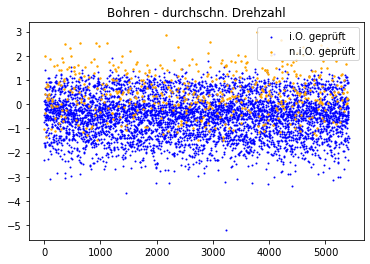

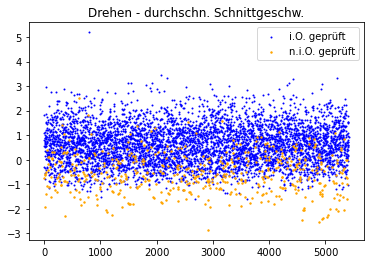

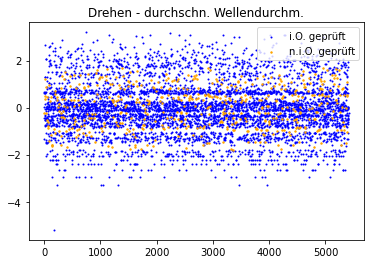

In [8]:
for i in range(data.shape[1]):  
    fig = plt.figure()
    plt.scatter([i for i in range(data.shape[0]) if target[i]==0], data[target==0, i], c='blue', label='i.O. geprüft', s=1)
    plt.scatter([i for i in range(data.shape[0]) if target[i]==1], data[target==1, i], c='orange', label='n.i.O. geprüft', s=2)
    plt.legend(loc=1)
    plt.title(col_names[i])
    fig.savefig('i_O_Verteilungs_{}.png'.format(i), format='png', dpi=1200, bbox_inches = "tight")
plt.show()

## Wirkzusammenhänge der Prozessparameter

Die vorangegangene Visualisierung hat die Fehlerverteilung im Hinblick auf die einzelnen Prozessparameter dargestellt. Im Folgenden werden die Wirkzusammenhänge zwichen den Prozessparameter im Hinblick auf das Qualitätsmerkmal mittels einer 3D-Visualisierung dargestellt. Ein solcher Wirkzusammenhang könnte bedeuten, dass ein Produktionsprozess trotz überdurchschnittlich hoher durchschnittlicher Drehzahl ein fehlerfreies Bauteil produziert, solange eine Mindestschnittgeschwindigkeit eingehalten wird.

In [9]:
def threeD_plot(data_io, data_nio, title = '', alpha_settings = [],axis_setting_01 = [], safe_as = ""):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(data_io[:, 0], data_io[:, 1], data_io[:, 2], c='blue', alpha=alpha_settings[0][0], s=alpha_settings[0][1], label='i.O.')
    sc = ax.scatter(data_nio[:, 0], data_nio[:, 1], data_nio[:, 2], c='orange', alpha=alpha_settings[1][0], s=alpha_settings[1][1], label='n.i.O.')
    ax.set_xlabel(col_names_short[0])
    ax.set_ylabel(col_names_short[1])
    ax.set_zlabel(col_names_short[2])
    if axis_setting_01: 
        ax.axis(axis_setting_01)
    legend = ax.legend()
    for lh in legend.legendHandles: 
        lh.set_alpha(1)
    plt.title(title)
    plt.show()
    if safe_as:
        fig.savefig('%s.png'%(safe_as), format='png', dpi=1200, bbox_inches = "tight")

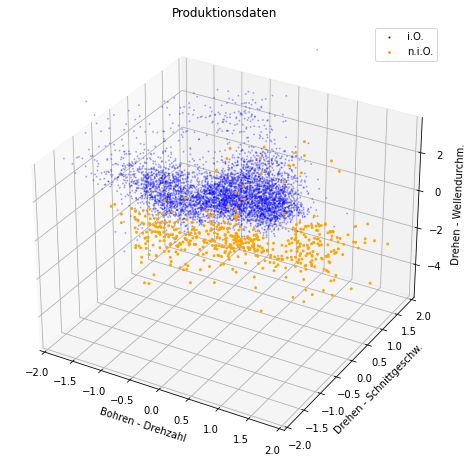

In [10]:
data_io = data[target==0, :]
data_nio = data[target==1, :]
threeD_plot(data_io, data_nio, title = 'Produktionsdaten', alpha_settings = [[0.25,1],[1,3.5]], axis_setting_01 = [-2,2,-2,2])

# Statistische Prozesskontrolle (vereinfacht)

Um die Potentiale von Machine Learning (ML) Algorithmen, die in der 3D-Visualisierung gezeigten, komplexe Muster in Datensätzen abbilden zu können hervorzuheben, wird im Folgenden der Vergleich mit einer konventionellen Methode des Qualitätsmanagements durchgeführt – einer vereinfachten statistischen Prozesskontrolle (SPC). Wie auch beim ML ist der Grundgedanke der SPC, Fehler anhand von Mustern zu erkennen. Das Muster der einfachen SPC ist der triviale Fall einer Abweichung einzelner Messgrößen vom Mittelwert.   
Die hierbei benötigten Angaben für Mittelwert und Standardabweichung der Features (bzw. Prozessparameter) werden im Folgenden berechnet.

In [17]:
print('Mittelwert, Standardabweichung fehlerhafter Teile:\n')
d = list()
for i in range(col_names.shape[0]):
    d.append([col_names[i],str(np.nanmean(data[target==1, i])),str(np.nanstd(data[target==1, i]))])
    
print(tabulate(d, headers=['Prozessschritt', 'Mittelwert', 'Standardabweichung']))

Mittelwert, Standardabweichung fehlerhafter Teile:

Prozessschritt                        Mittelwert    Standardabweichung
----------------------------------  ------------  --------------------
Bohren - durchschn. Drehzahl           0.491797               0.903428
Drehen - durchschn. Schnittgeschw.    -0.561145               0.78664
Drehen - durchschn. Wellendurchm.      0.0336125              0.878218


## Regelkarte

Im Folgenden wird die Regelkarten erstellt und auf die Eingriffsgrenze hin ausgewertet. Sobald diese überschritten wird, ist das gefertigte Teil als fehlerhaft einzustufen und wird aussortiert. Bei der optischen Analyse der Graphen wird deutlich, dass ein Großteil der als n.i.O. identifizierten Bauteile innerhalb beider Grenzen liegen und somit anhand der Regelkarte nicht aussortiert wird.

<Figure size 432x288 with 0 Axes>

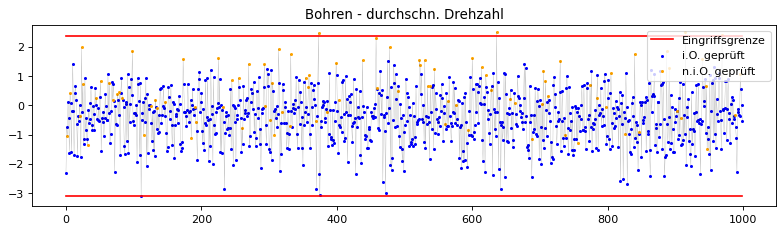

<Figure size 432x288 with 0 Axes>

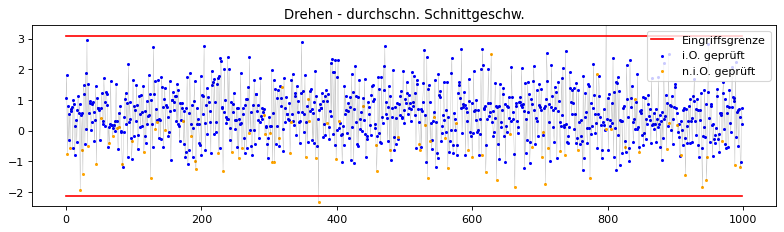

<Figure size 432x288 with 0 Axes>

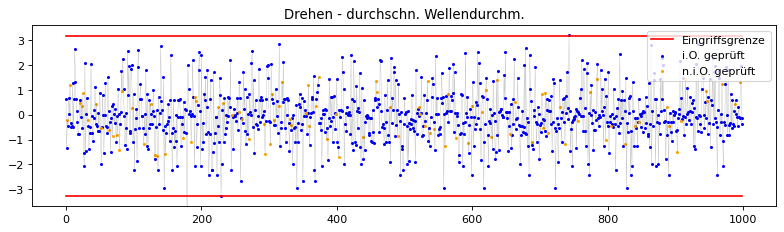

<Figure size 432x288 with 0 Axes>

In [31]:
data_test = data[0:1000] #Testdatensatz, ca. 20% der verfügbaren Daten
target_test = target[0:1000]

color = list()
for i in range(0, data_test.shape[0]):
    color.append(1 if 1 in target_test[i:i+1] else 0)
    #x_q.append([np.nanmean(data[i:i+m,0]),np.nanmean(data[i:i+m,1]),np.nanmean(data_test[i:i+m,2])])
color = np.array(color)

err_det = list() #Durch die Eingriffsgrenzen definierter Fehler
err_true = list() #Tatsächlicher Fehler, der von den Eingriffsgrenzen detektiert wurde.

for i in range(data_test.shape[1]):
    avg = np.nanmean(data_test[:, i])
    std = np.nanstd(data_test[:, i])
    oeg = avg + 3*std
    ueg = avg - 3*std
    owg = avg + 2*std
    uwg = avg - 2*std
    
    fig = plt.figure()
    plt.figure(figsize=(12, 3), dpi=80)
    plt.plot(range(data_test.shape[0]), data_test[:, i], c='black', linewidth=0.3, alpha=0.3)
    plt.scatter([i for i in range(data_test.shape[0]) if color[i]==0], data_test[color==0, i], c='blue', label='i.O. geprüft', s=3)
    plt.scatter([i for i in range(data_test.shape[0]) if color[i]==1], data_test[color==1, i], c='orange', label='n.i.O. geprüft', s=3)
    plt.plot(range(data_test.shape[0]), [oeg for _ in range(data_test.shape[0])], c='red', label='Eingriffsgrenze')
    plt.plot(range(data_test.shape[0]), [ueg for _ in range(data_test.shape[0])], c='red')
    #plt.plot(range(data_test.shape[0]), [owg for _ in range(data_test.shape[0])], c='orange', label='Warngrenze')
    #plt.plot(range(data_test.shape[0]), [uwg for _ in range(data_test.shape[0])], c='orange')
    plt.ylim((avg-3.4*std),(avg+3.4*std))
    plt.legend(loc=1)
    plt.title(col_names[i])
    err_det.append(np.logical_or(data_test[:,i] > oeg, data_test[:,i] < ueg))
    err_true.append(np.logical_and(err_det[i], np.array(color)))
plt.show()
#lt.savefig('regelkarten.png')

Wie viele der fehlerhaften Bauteile durch die Regelkarten der einzelnen Prozessschritte richtig identifiziert werden können, wird im Folgenden ausgegeben. Zudem wird geprüft, welche Aussagekraft die Kombination der drei Regelkarten auf die Prozessqualität hat.

In [20]:
print('Richtig klassifizierte Fehler durch die einzelnen Regelkarten:')
for i in range(len(err_true)):
    print(str(col_names[i]) + ': %s' %(np.sum(err_true[i])))
fehler_gesamt = target_test
err_true_kombiniert = np.logical_or(err_true[0],np.logical_or(err_true[1],err_true[2]))
err_det_kombiniert = np.logical_or(err_det[0],np.logical_or(err_det[1],err_det[2]))
print("\nRichtig klassifizierte Fehler durch die Kombination der Regelkarten: %s" %(sum(err_true_kombiniert)))
print("Fehler im Testdatensatz: %s" %(round(sum(target_test))))

Richtig klassifizierte Fehler durch die einzelnen Regelkarten:
Bohren - durchschn. Drehzahl: 4
Drehen - durchschn. Schnittgeschw.: 1
Drehen - durchschn. Wellendurchm.: 0

Richtig klassifizierte Fehler durch die Kombination der Regelkarten: 4
Fehler im Testdatensatz: 94


In [21]:
def confu_plot(target, prediction, pred_lable = 'Prediction', title = ""):
    
    group_names = ['Korrekt i.O.','Falscher Eingriff','Versäumter Eingriff','Richtiger Eingriff']
    
    cf_matrix_spc  = confusion_matrix(target,prediction)

    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix_spc.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix_spc.flatten()/np.sum(cf_matrix_spc)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix_spc, annot=labels, fmt='', cmap='Blues')

    ax.set_title(title);
    ax.set_xlabel('\n%s'%(pred_lable))
    ax.set_ylabel('Realität');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

Aus der vorherigen Analyse ist zu erkennen, dass die Kombination der drei Regelkarten nur 22 der 496 vorhandenen Fehler richtig identifiziert. Um diese Klassifizierung detaillierter zu betrachten, den Alpha- und Beta-Fehler aufzuzeigen, wird eine Confusion Matrix erstellt. 

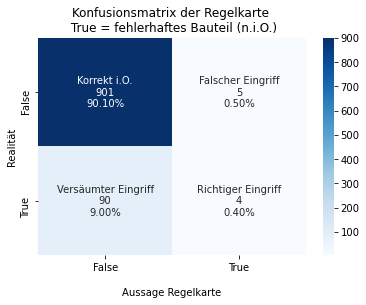

<Figure size 432x288 with 0 Axes>

In [23]:
confu_plot(target_test,err_det_kombiniert, 'Aussage Regelkarte', 'Konfusionsmatrix der Regelkarte \n True = fehlerhaftes Bauteil (n.i.O.)')
#plt.savefig('regelkarte_confu.png')

# Künstliche Neuronale Netze

Das Beispiel der Prozessanalyse durch vereinfachte Regelkarten hat gezeigt: Die Betrachtung isolierter Prozessparameter, sowie deren Überlagerung ist in dem gegebenen Anwendungsfall nicht zielführend.  Zusammenhänge und Interaktionen, die bei gemeinsamem Auftreten Fehler begünstigen oder verhindern, können nicht abgebildet werden. Es wird eine komplexere Betrachtung benötigt, um diese Zusammenhänge zu entschlüsseln. Hierzu bieten sich Künstliche Neuronale Netze (KNN) an. Die Voraussetzung zur Nutzung von KNNs ist das Vorhandensein von historischen Daten, anhand derer die funktionalen Zusammenhänge zwischen Prozessparametern und Qualitätsmerkmal erlernt werden können, sodass anhand von zukünftigen Prozessparametern Prognosen hinsichtlich des Qualitätsmerkmals möglich sind. Die Prozessparameter werden dem neuronalen Netz als Input übergeben und die Ergebnisse (ob ein Teil bei den entsprechenden Parametern fehlerhaft oder nicht ist) als Vergleichswert der Prognose. 
Ein künstliches neuronales Netz ist ein Netzwerk bestehend aus einer Vielzahl künstlicher Neuronen, die eine nichtlineare Transferfunktion enthalten. Transferfunktionen sind Funktionen, die eine Eingangsgröße in eine gewünschte Ausgangsgröße umrechnen. Eine beliebte Transferfunktion künstlicher neuronaler Netze ist zum Beispiel der Tangens Hyperbolicus, der jede Eingangsgröße in eine Ausgangsgröße zwischen -1 und 1 umrechnet. Durch eine Verschachtelung der Transferfunktionen können komplexe funktionelle Zusammenhänge abgebildet werden. Die Eingangsgrößen bzw. der Input künstlicher Neuronen wird mit einem Gewicht multipliziert sowie ein Schwellenwerten addiert. Die Gewichte und Schwellenwerte werden vom neuronalen Netz durch einen Lernalgorithmus parametriert.
Aber wie funktioniert dieser Lernalgorithmus? Woher weiß das neuronale Netz wie die Gewichte und Schwellenwerte eingestellt werden müssen, damit über die Transferfunktionen genau unser gewünschter Output berechnet wird?     
Während der Initialisierung erhält das Neuronale Netz beliebigen Gewichten und Schwellenwerte. Mittels gegebener Features aus dem Trainingsdatensatz wird berechnet, ob die gefertigten Teile fehlerbehaftet sind oder nicht. Diese Prognosen werden mit den initialisierten Werten rein zufällig sein. Das Netz wird anfänglich viele Fehler machen, doch genau aus diesen Fehlern wird wissen generiert. Durch den Abgleich der Prognosen mit dem wahren Qualitätsmerkmal der Bauteile, wird berechnet, in welche Richtung (positiv oder negativ) die Gewichte und Schwellenwerte geändert werden müssen, damit sich die Prognosegüte verbessert. Dies geschieht über die Nutzung von partiellen Ableitungen. Um eine starke Überkorrektur der Anpassungen zu vermeiden, wird der Betrag der Änderung pro Trainingsschritt begrenzt, durch die sogenannte Lernrate. Dieses Vorgehen (iterative Anpassungen des Neuronalen Netzes) wird wiederholt, bis die Gesamtmenge an Fehlern ein Minimum erreicht.    

#### Aufteilung der Test- und Trainingsdaten

Beim Training von Neuronalen Netzen anhand von historischen Daten besteht eine große Herausforderung darin, allgemeingültige funktionale Prozesszusammenhänge zu identifizieren anstelle des Auswendiglernens der Zusammenhänge im Trainingsdatensatz. Dieses Problem nennt man "overfitting", man "fitted" die Gewichte und Schwellenwerte zu stark an die Beispiele an. Um zu prüfen, ob das Netz gute, allgemeingültige Vorhersagen trifft, wird der Datensatz daher immer in Trainings- und Testdaten aufgeteilt (wie im hier folgenden Programmcode gezeigt). Die Trainingsdaten werden genutzt, um die Gewichte und Schwellenwerte zu optimieren und die Testdaten werden anschließend genutzt, um die Prognosegüte des Neuronalen Netzes basierend auf ihm unbekannten Daten zu testen.

In [24]:
data_test = data[0:1000] #Testdatensatz, ca. 20% der verfügbaren Daten
target_test = target[0:1000]

data_train = data[1000:]
target_train = target[1000:]

#### Training des Künstlichen Neuronalen Netzes

Nachdem der Datensatz in Trainings- und Testdaten aufgeteilt wurde, wird das neuronale Netz nun mit den Trainingsdaten trainiert. Es wird der "MLPClassifier" genutzt, da es sich hierbei um ein Klassifikationsproblem handelt. Klassifikation heißt, unser Ergebnis kann in konkrete Klassen eingeteilt werden (hier: "fehlerbehaftet" oder "nicht-fehlerbehaftet") und das neuronale Netz versucht anhand der Inputdaten herauszufinden, zu welcher Klasse ("fehlerbehaftet" oder "nicht-fehlerbehaftet") das Teil gehört. Der andere (hier nicht betrachtete) Fall wäre ein Regressionsproblem, welches bei kontinuierlichen Ergebnissen genutzt wird, z.B. bei der Vorhersage der Durchlaufzeit eines Produkts.   
Über die Funktion "hidden_layer_sizes=(16, 4)" im MLPClassifier lassen sich die einzelnen Neuronen der sogenannten Hidden Layer einstellen, diese enthalten die Transferfunktionen, in unserem Beispiel sind zwei Hidden Layer eingestellt. Die erste mit 16 künstlichen Neuronen und die zweite mit 4. Die optimalen Parameter für die Hidden Layer können durch systematisches prüfen gefunden werden. 

In [25]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(12, 4), random_state=42,  
                    max_iter=2000, n_iter_no_change=50, validation_fraction=0.)
clf.fit(data_train, target_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(12, 4), max_iter=2000,
              n_iter_no_change=50, random_state=42, solver='lbfgs',
              validation_fraction=0.0)

#### Prognosegüte des Künstlichen Neuronalen Netzes 

Nachdem das KNN mit dem Trainingsdatensatz trainiert ist, werden Prognosen basierend auf dem Testdatensatz durchgeführt. Um die Genauigkeit der Vorhersagen zu prüfen, werden die Vorhersagen mit dem binären Datensatz verglichen, der die tatsächlichen Fehler (Qualitätsmerkmale) beinhaltet.

In [26]:
print('Genauigkeit der Vorhersagen des KNN: {}%'.format(clf.score(data_test, target_test)*100))
print('Anzahl der Parameter im KNN: ',(sum([a.size for a in clf.coefs_]) +  
            sum([a.size for a in clf.intercepts_])))

Genauigkeit der Vorhersagen des KNN: 99.2%
Anzahl der Parameter im KNN:  105


Bei der Fehlererkennung von Produkten macht es einen Unterschied, ob vorhandene Fehler nicht erkannt werden (falsch-negative Prognose), oder ein Produkt als fehlerhaft kategorisiert wird, obwohl es fehlerfrei ist (falsch-positive Prognose). Falsch-negativ klassifizierte Produkte werden an Kunden ausgeliefert und verursachen aufgrund von Reklamationsvorgängen und Imageschäden deutlich höhere mittel- und langfriste Kosten als falsch-positiv klassifizierte Produkte.    
Um die Leistung des neuronalen Netzes bewerten zu können und eine Vergleichbarkeit zu der vorangegangenen Klassifizierung durch die Regelkarten herzustellen, wird im Folgenden die Confusion Matrix erstellt. Das neuronale Netz hat im Testdatensatz von insgesamt 1000 Produkten drei falsch-positiv und fünf falsch-negativ deklariert, ein deutlich besseres Ergebnis als mittels der Regelkarten.

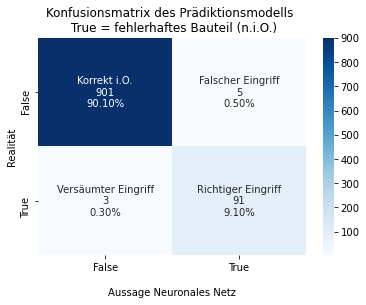

<Figure size 432x288 with 0 Axes>

In [28]:
predictions = clf.predict(data_test)
confu_plot(target_test,predictions, 'Aussage Neuronales Netz', 'Konfusionsmatrix des Prädiktionsmodells \n True = fehlerhaftes Bauteil (n.i.O.)')
#plt.savefig('pq_confu.png')

## Lösungsraums des Neuronalen Netzes
Mit der nachgelagerten Simulation des Lösungsraums des neuronalen Netzes  wird graphisch aufgezeigt, welche Paramterkombinationen vom neuronalen Netz als fehlerhaft oder fehlerfrei klassifiziert werden. Dadurch kann das Verhalten des neuronalen Netzes für bisher ungetestete Parameterkonfigurationen veranschaulicht werden.    
Zunächst drei Vektoren gebildet, die aus 50 gleichmäßig verteilten Werten zwischen -1.5 und 1.5 bestehen. Durch Änderung dieser Werte kann der später aufgezeigte Lösungsraum vergrößert oder verkleinert werden. Jeder dieser Vektoren repräsentiert dabei jeweils einen der Prozessparameter: *Bohren - durchschn. Drehzahl*, *Drehen - durchschn. Schnittgeschw.* und *Drehen - durchschn. Wellendurchmesser*

In [29]:
start = -1.5
stop = 1.5

x_0 = np.linspace(start, stop, 50)
x_1 = np.linspace(start, stop, 50)
x_2 = np.linspace(start, stop, 50)

Anhand der drei Vektoren (50x50x50) werden 125.000 Vorhersagen mittels des neuronalen Netzes getroffen.   

In [26]:
nn_cube = []
for xx_0 in x_0:
    for xx_1 in x_1:
        for xx_2 in x_2:
            pred = clf.predict(np.array([[xx_0, xx_1, xx_2]]))[0]
            nn_cube.append([xx_0, xx_1, xx_2, pred])
nn_cube = np.array(nn_cube)
print(nn_cube.shape)

(125000, 4)


Anschließend werden die 125.000 Vorhersagen in einer 3D Darstellung visualisiert. Der blaue Bereich bildet denjenigen Bereich ab, die das künstliche neuronale Netz als fehlerfrei klassifiziert. Der gelbe Bereich bilden den Bereich ab, den das künstliche neuronale Netz als fehlerhaft klassifiziert. Die Gegenüberstellung zur vorherigen 3D Visualisierung der historischen Daten zeigt starke Ähnlichkeiten auf.

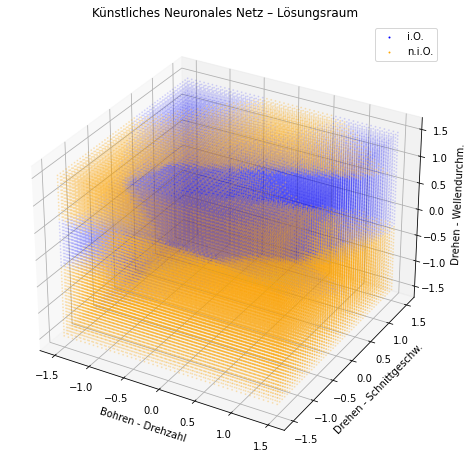

In [27]:
nn_cube_0 = nn_cube[nn_cube[:, 3]==0, :]
nn_cube_1 = nn_cube[nn_cube[:, 3]==1, :]
threeD_plot(nn_cube_0, nn_cube_1, title = 'Künstliches Neuronales Netz – Lösungsraum', alpha_settings = [[0.1,1],[0.2,0.9]])

# Potentielle Kosteneinsparung durch Predictive Quality

Im Anschluss an die Modelbildung wird die Kosteneinsparungen bei der Fehlervorhersage mit künstlichen Neuronalen Netzen berechnet und mit der manuellen 100% und 50% Qualitätsprüfung verglichen. Der Vergleich unterliegt einer Vielzahl von Vereinfachungen und soll dementsprechend ausschließlich einer groben Abschätzung zur Gegenüberstellung dienen.
Im folgenden Programmteil können zunächst die Parameter für die Kostenberechnung eingestellt werden. 


In [28]:
# Stundenlohn Prüfpersonal    
personal_stundenlohn = 45

# Prüfzeit in Stunden pro Produkt
pruefzeit = 3/60

# Durchschnittliche Fehlerquote in der Fertigung (basierend auf historischen Daten) 
fehlerquote = np.count_nonzero(target)/target.shape[0]

# Herstellungskosten (pro Produkt) 
herstellungskosten = 50

# Retourkosten (pro Produkt)
retourkosten = 20 #incl. Bearbeitungszeit

Im Folgenden werden die Qualitätskosten anhand der zuvor eingestellten Parameter berechnet. 
Die Kosten für eine 100% Qualitätskontrolle setzen sich aus den Prüfkosten zusammen.

Die Kosten für eine 50% Qualitätskontrolle setzen aus den Prüfkosten sowie den Retourkosten für die ausgelieferten Bauteile mit Qualitätsmängeln zusammen.
Die Kosten für das neuronale Netz setzen aus den falsch-positiven Klassifikationen die ohne Qualitätsmängel aussortiert werden, sowie den den falsch-negativen klassifizierten Produkten, die aufgrund von Qualitätsmängeln retourniert werden zusammen. 

Es ist zu erkennen, dass das der Ansatz über das künstliche neuronale Netz in unserem Beispiel die niedrigsten Qualitätsprüfungskosten verursacht.


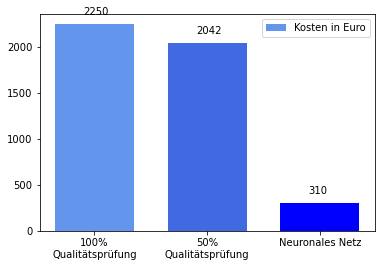

In [29]:
# Berechnet die durch Fehler verursachten Kosten bei 100% Qualitätsprüfung, 50% Qualitätsprüfung und fehlerhafter Vorhersage durch das Neuronale Netz
anzahl_produkte = data_test.shape[0]
tp, false_positive, false_negative, tp = confusion_matrix(target_test,predictions).ravel()
pruefkosten = personal_stundenlohn * pruefzeit

#100% Qualitätsprüfung
cost_qualitaetspruefung_100 = anzahl_produkte * pruefkosten

#50% Qualitätsprüfung
cost_qualitaetspruefung_50 = anzahl_produkte * (1/2 * pruefkosten + 1/2 * fehlerquote * retourkosten)

# Neuronalen Netz
cost_nn = false_positive * herstellungskosten + false_negative * retourkosten

kosten = [cost_qualitaetspruefung_100, cost_qualitaetspruefung_50, cost_nn]

fig = plt.figure()
plt.bar([0,0], cost_qualitaetspruefung_100, width=0.7, color='cornflowerblue', label='100% Qualitätsprüfung')
plt.bar([1,1], cost_qualitaetspruefung_50, width=0.7, color='royalblue', label='50% Qualitätsprüfung')
plt.bar([2,2], cost_nn, width=0.7, color='blue', label='Neuronales Netz')
plt.xticks([0,1,2], ['100%\nQualitätsprüfung','50%\nQualitätsprüfung','Neuronales Netz'])
plt.legend(['Kosten in Euro'])
for i, v in enumerate(kosten):
    plt.text(i-0.1, v+100, str(round(kosten[i])))
plt.show()

(c) Werkzeugmaschinenlabor (WZL) der RWTH Aachen